<a href="https://colab.research.google.com/github/google/telluride_decoding/blob/master/Telluride_Decoding_Toolbox_TF2_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Telluride Decoding Toolbox, TF2 Version

This colab demonstrates the basic operation of the Telluride Decoding Toolbox. The toolbox is designed for large-scale experiments, where the raw data is stored on disk because is too large to fit into memory, or you want to run multiple decoding jobs in parallel for hyperparameter searches.


In general, there are three stages to our decoding pipeline: ingest, decode, decide. This colab demonstrates the first two.

1.   Ingest the raw data, and store it on disk in TFRecord format. This is the native format for Tensorflow, and each file consists of the raw audio and brain data, one (vector) sample per time step for one continuous trial.  Multiple forms of the data can be stored in each record.  Thus you might have 64 channels of EEG data, the audio intensity, as well as perhaps the phone class and the corresponding spectrogram.  All data is sampled as the same frame rate (i.e. 100Hz).
2.   Build a decoding model. The decoding model can take several forms, such as linear regression, CCA or several forms of DNN. When building regression models you specify which input fields (from the TFRecord data) are used as input, along with any desired temporal context, and which field is the output and to be predicted. For a backward model you might use EEG with 30 frames of post_context to predict the current (audio) intensity.  For CCA you specify two sets of input fields, which are rotated to provide the highest correlation.
3.    Decide to which signal the subject is attending. This code implements a State Space Model (from Maryland) and a simple Markov model suggested by KUL.

It uses EEG data, first published as part of version 1 of the Telluride Decoding Toolbox. This data consists of 32 trials from four simultaneous subjects listening to 4 different audio tracks. There are 64 electrodes in each trial, split across the 4 subjects. The original data is provided in Matlab format and is downloaded by the colab.

This colab shows how to download and import the toolbox, download and import the original Matlab data, and then measure linear and CCA models predicting the intensity that generated the EEG data.
This is a work in progress.  Comments and/or questions are welcome as we finalize the documention and the code. The source code (a lousy way to document the toolkit) is available on [GitHub](https://github.com/google/telluride_decoding).



##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Default title text
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#Install the right software 
(telluride-decoding plus prereqs)

In [1]:
!pip uninstall -y telluride-decoding

In [2]:
# To get test versions and install them on this machine.
# !pip install mock pyedflib  # Need to list these since they are not on test.pypi
# !pip install --index-url https://test.pypi.org/project telluride-decoding

In [3]:
# To install the latest released version:
!pip install telluride-decoding

     |████████████████████████████████| 112kB 2.8MB/s 
     |████████████████████████████████| 1.1MB 7.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pyedflib: filename=pyEDFlib-0.1.18-cp36-cp36m-linux_x86_64.whl size=603304 sha256=94ce9bf7af800930122fb580d423f4855d9208e82937549a5b7a7b1d1f9ff7e0
  Stored in directory: /root/.cache/pip/wheels/4c/16/32/829749d6ab56f64e81e44aed0b4b9a892c975512c15cc3edbb
Successfully built pyedflib


In [4]:
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

tf.compat.v1.enable_v2_behavior()

In [5]:
from telluride_decoding import brain_data
from telluride_decoding import brain_model
from telluride_decoding import decoding
from telluride_decoding import regression
from telluride_decoding import regression_data

# Reset the plot library backend to the default. 
import matplotlib
matplotlib.use('module://ipykernel.pylab.backend_inline')

# Force flags to be parsed (none here) to set flag defaults. There are some parts
# of the toolbox that still use FLAGS, but shouldn't :-(
from absl import flags
flags.FLAGS(['colab'])  # Cause flags library to set the default.

['colab']

In [6]:
telluride_data = regression_data.RegressionDataTelluride4()
cache_dir = '/tmp'
telluride4_url = 'https://drive.google.com/uc?id=0ByZjGXodIlspWmpBcUhvenVQa1k'

if not telluride_data.is_data_local(cache_dir):
  print('Downloading the Telluride4 data...')
  telluride_data.download_data(telluride4_url, cache_dir)

In [7]:
tf_dir = '/tmp/telluride_tf'
!mkdir {tf_dir}
if not telluride_data.is_data_ingested(tf_dir):
  print('Ingesting the Telluride4 data...')
  telluride_data.ingest_data(cache_dir, tf_dir, 100)

Ingesting the Telluride4 data...


In [8]:
!ls {tf_dir}

README.txt	    trial_09.tfrecords	trial_18.tfrecords  trial_27.tfrecords
trial_01.tfrecords  trial_10.tfrecords	trial_19.tfrecords  trial_28.tfrecords
trial_02.tfrecords  trial_11.tfrecords	trial_20.tfrecords  trial_29.tfrecords
trial_03.tfrecords  trial_12.tfrecords	trial_21.tfrecords  trial_30.tfrecords
trial_04.tfrecords  trial_13.tfrecords	trial_22.tfrecords  trial_31.tfrecords
trial_05.tfrecords  trial_14.tfrecords	trial_23.tfrecords  trial_32.tfrecords
trial_06.tfrecords  trial_15.tfrecords	trial_24.tfrecords
trial_07.tfrecords  trial_16.tfrecords	trial_25.tfrecords
trial_08.tfrecords  trial_17.tfrecords	trial_26.tfrecords


In [9]:
!cat {tf_dir}/README.txt

These files were ingested from: /tmp
Using: ['/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py', '-f', '/root/.local/share/jupyter/runtime/kernel-4355a618-0ec2-4fc9-abcf-abeb6c49ae8d.json']
With a output frame rate of 100Hz

Feature shapes are:
	eeg: FixedLenFeature(shape=[63], dtype=tf.float32, default_value=None)
	ones: FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None)
	intensity: FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None)

All ingested files:
	/tmp/telluride_tf/trial_01.tfrecords: 8297 records (82.97 seconds) 
	/tmp/telluride_tf/trial_02.tfrecords: 8024 records (80.24 seconds) 
	/tmp/telluride_tf/trial_03.tfrecords: 8072 records (80.72 seconds) 
	/tmp/telluride_tf/trial_04.tfrecords: 7867 records (78.67 seconds) 
	/tmp/telluride_tf/trial_05.tfrecords: 8297 records (82.97 seconds) 
	/tmp/telluride_tf/trial_06.tfrecords: 8024 records (80.24 seconds) 
	/tmp/telluride_tf/trial_07.tfrecords: 8072 records (80.72 seconds) 
	/tmp/telluride_tf

#Decode the Telluride4 EEG Data

In [10]:
# If you have problems or get unexplained errors, you might want to turn on
# log messages with these calls.  Change the False to True to enable the logging.
if False:
  from absl import logging
  logging.set_verbosity(logging.INFO)
  logging.set_stderrthreshold('info')
  logging.info('Testing')

In [11]:
telluride4_options = decoding.DecodingOptions()
telluride4_options.input_field = 'eeg'
telluride4_options.output_field = 'intensity'
telluride4_options.input2_field = 'intensity'

telluride4_options.tfexample_dir = tf_dir

telluride4_options.dnn_regressor = 'cca'
telluride4_options.post_context = 21
telluride4_options.input2_pre_context = 15
telluride4_options.input2_post_context = 15
telluride4_options.test_metric = 'cca_pearson_correlation_first'
telluride4_options.shuffle_buffer_size = 0  # No need when training a CCA model
telluride4_options.cca_dimensions = 5


In [12]:
print(telluride4_options.experiment_parameters('\n'))

attended_field=attend
batch_norm=False
batch_size=512
cca_dimensions=5
check_file_pattern=
correlation_frames=100
correlation_reducer=lda
data=tfrecords
debug=False
dnn_regressor=cca
dropout=0.0
epoch_count=100
frame_rate=100.0
hidden_units=20-20
input2_field=intensity
input2_post_context=15
input2_pre_context=15
input_field=eeg
learning_rate=0.05
loss=mse
min_context=0
output_field=intensity
post_context=21
pre_context=0
random_mixup_batch=False
regularization_lambda=0.1
saved_model_dir=None
shuffle_buffer_size=0
summary_dir=/tmp/tf
tensorboard_dir=None
test_file_pattern=
test_metric=cca_pearson_correlation_first
tfexample_dir=/tmp/telluride_tf
tfexample_pattern=
train_file_pattern=
validate_file_pattern=


In [13]:
telluride4_data = regression.get_brain_data_object(telluride4_options)

In [14]:
# Get the actual TF dataset, as an example of the full TDT data object.
telluride4_dataset = telluride4_data.create_dataset('train')

# Create the brain model (CCA as specified above.)
brain_model = decoding.create_brain_model(telluride4_options, telluride4_dataset)

In [15]:
# Now train the regressor. Since this regressor is built with CCA, only one
# pass through the data is needed to collect the statistics and create the model.
train_results, test_results = decoding.train_and_test(telluride4_options, telluride4_data, brain_model)

504/504 [==============================] - 8s 15ms/step - loss: 0.1268 - cca_pearson_correlation_first: 0.1268


In [16]:
test_results

{'cca_pearson_correlation_first': 0.1267634630203247,
 'loss': 0.1267634630203247}

#Run complete jackknife test

Run a complete jackknife (leave-one-out) test using the Telluride4 data. This takes a while to run, but gives us error bounds (really standard deviations).  Compute the test-set correlation when using CCA.

In [ ]:
telluride4_regression = regression.Telluride4CCA(telluride4_options)

In [ ]:
reg_values = np.power(10.0, np.arange(-3, 2, 1))
results = telluride4_regression.jackknife_over_regularizations(telluride4_options, 
                                                               reg_values)

Before creating the first dataset train, validate, and test: allbut , /tmp/telluride_tf/trial_10.tfrecords , /tmp/telluride_tf/trial_10.tfrecords
15/15 [==============================] - 0s 27ms/step - loss: 0.1317 - cca_pearson_correlation_first: 0.1317
Writing summary data for one jackknife: Jackknife test result test=telluride4, regularization lambda=0.001, trial=0, mean correlation=0.02029889329787693, std=0.06304294896872671, test count=32
Jackknife parameters:attended_field=attend,batch_norm=True,batch_size=100,cca_dimensions=5,check_file_pattern=,correlation_frames=100,correlation_reducer=lda,data=tfrecords,debug=False,dnn_regressor=cca,dropout=0.0,epoch_count=1,frame_rate=100.0,hidden_units=20-20,input2_field=intensity,input2_post_context=15,input2_pre_context=15,input_field=eeg,learning_rate=0.05,loss=mse,min_context=0,output_field=eeg,post_context=21,pre_context=0,random_mixup_batch=False,regularization_lambda=0.001,saved_model_dir=None,shuffle_buffer_size=0,summary_dir=/tmp/

In [ ]:
results

OrderedDict([(0.001, (0.02029889329787693, 0.06304294896872671)),
             (0.01, (0.1114157076808624, 0.04458894398903352)),
             (0.1, (0.11169882147805765, 0.04485586837626001)),
             (1.0, (0.10712250381766353, 0.04694820653993128)),
             (10.0, (0.08286182796291541, 0.04749923574835863))])

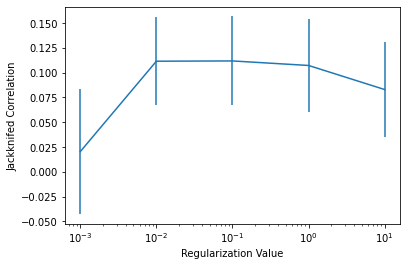

In [ ]:
reg_values = list(results.keys())
result_means = [results[k][0] for k in reg_values] 
result_stddev = [results[k][1] for k in reg_values] 
plt.errorbar(reg_values, result_means, result_stddev)
matplotlib.pyplot.xscale('log')
plt.xlabel('Regularization Value')
plt.ylabel('Jackknifed Correlation');